In [1]:
import numpy as np
from rich import print as pprint
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import itertools
import operator

from midstack.interface.analog.operator import *
from midstack.interface.analog.operation import *
from midstack.backend.metric import *
from midstack.backend.task import Task, TaskArgsAnalog
from midstack.backend import QutipBackend

In [2]:
def sum(args):
    return functools.reduce(operator.add, args)


def prod(args):
    return functools.reduce(operator.mul, args)


def tensor(args):
    return functools.reduce(operator.matmul, args)

In [3]:
X = PauliX()
Y = PauliY()
Z = PauliZ()
I = PauliI()

n = 6

In [4]:
field = sum([tensor([X if i == j else I for i in range(n)]) for j in range(n)])
interaction = sum(
    [tensor([Z if j in (i, (i + 1) % n) else I for j in range(n)]) for i in range(n)]
)

hamiltonian = AnalogGate(hamiltonian=field + interaction)

circuit = AnalogCircuit()
circuit.evolve(duration=1, gate=hamiltonian)

In [5]:
# define task args
args = TaskArgsAnalog(
    n_shots=100,
    fock_cutoff=4,
    metrics={
        f"Z_{i}": Expectation(operator=tensor([Z if j == i else I for j in range(n)]))
        for i in range(n)
    },
    dt=1e-2,
)
task = Task(program=circuit, args=args)

In [6]:
backend = QutipBackend()
expt, args = backend.compile(task=task)
results = backend.run(experiment=expt, args=args)

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Expectation value')]

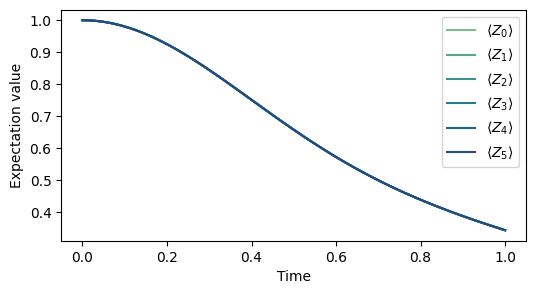

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=max([4, n]))

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.legend()
ax.set(xlabel="Time", ylabel="Expectation value")

[Text(0.5, 0, 'Basis state'),
 Text(0, 0.5, 'Amplitude (imag)'),
 (-3.141592653589793, 3.141592653589793)]

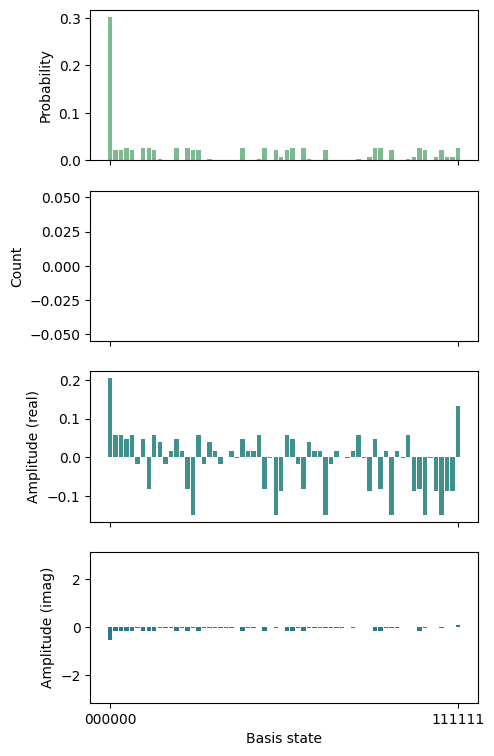

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = ["".join(bits) for bits in itertools.product("01", repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state) ** 2, color=colors[0])
ax.set(ylabel="Probability")


ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")


ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set_xticks([bases[0], bases[-1]])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi])